# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [0]:
running_on_google_colab = True

if running_on_google_colab:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

    !pip install Pillow==4.1.1

    !wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
    !unzip Cat_Dog_data.zip

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import time

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [3]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=125, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=125, shuffle=True)

print(f'trainloader: {len(trainloader)} batches; {len(trainloader.dataset)} images')
print(f'testloader: {len(testloader)} batches; {len(testloader.dataset)} images')

trainloader: 180 batches; 22500 images
testloader: 20 batches; 2500 images


We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [0]:
model = models.densenet121(pretrained=True)
model

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [0]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    start = time.time()
    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==1:
            break

    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [7]:
## Use a pretrained model to classify the cat and dog images

resnet = models.resnet152(pretrained=True)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [8]:
# freeze feature parameters
for param in resnet.parameters():
    param.requires_grad = False

# change the classifier
classifier = nn.Sequential(nn.Linear(2048,1024),
                           nn.ReLU(),
                           nn.Dropout(p=0.5),
                           nn.Linear(1024,2),
                           nn.LogSoftmax(dim=1))
resnet.fc = classifier
print(resnet.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=1024, out_features=2, bias=True)
  (4): LogSoftmax()
)


In [0]:
def heatmap(accuracy_graph):
    fig, ax = plt.subplots(figsize=(15,3))
    ax.grid(False)
    im = ax.imshow(accuracy_graph, cmap='YlGn')


    # We want to show all ticks...
    ax.set_xticks(np.arange(len(testloader)))
    ax.set_yticks(np.arange(2))
    # ... and label them with the respective list entries
    #ax.set_xticklabels(farmers)
    ax.set_yticklabels(['cats', 'dogs'])

    textcolors = ['k','w']
    # Loop over data dimensions and create text annotations.
    for i in range(2):
        for j in range(len(testloader)):
            text = ax.text(j, i, f'{accuracy_graph[i, j]*100:.2f}%',
                           ha="center", va="center", color=textcolors[im.norm(accuracy_graph[i, j])>0.7])

    ax.set_title("Accuracy to classify cat and dog images")
    fig.tight_layout()
    plt.show()


In [0]:
# Verify if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to device
resnet.to(device)

# Define criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.003)

In [0]:
steps = 0
actual_accuracy = 0.0
trace_train_loss = []
trace_test_loss = []
trace_accuracy = []

In [0]:
# Define parameter for training
epochs = 1
desired_accuracy = 1.0
check_every = 18

start_time = time.time()

# Train
for epoch in range(epochs):
    # Stop if desired accuracy has been reached
    if actual_accuracy >= desired_accuracy:
        break

    # Set network to train
    resnet.train()

    # Train loop: iterate over batchs
    train_loss = 0
    for images, labels in trainloader:
        # Move tensors to device
        images, labels = images.to(device), labels.to(device)

        # Clean optimizer history
        optimizer.zero_grad()

        # Pass inputs into network and get tensor with log of probabibilities
        log_ps = resnet(images)
        # Calculate the Error Function
        loss = criterion(log_ps, labels)
        # Do the backpropagation
        loss.backward()
        # Optimize the weights
        optimizer.step()
        steps += 1

        # Save error value for statistics
        train_loss += loss.item()

        # Check if is time to do the validation
        if steps % check_every == 0:
            # Set network to validation
            resnet.eval()

            # Validation loop: iterate over batchs
            test_loss = 0
            accuracy = 0
            accuracy_graph = np.zeros((2,len(testloader)))
            with torch.no_grad():
                for batch, (images, labels) in enumerate(testloader):
                    # Move tensors to device
                    images, labels = images.to(device), labels.to(device)

                    # Pass inputs into network and get tensor with log of probabibilities
                    log_ps = resnet(images)
                    # Calculate the Error Function
                    loss = criterion(log_ps, labels)
                    # Save error value for statistics
                    test_loss += loss.item()

                    # Check the accuracy for this batch
                    # Get probabilities from log of probabilities
                    ps = torch.exp(log_ps)
                    # Get the most likely class for each input
                    top_p, top_class = ps.topk(1, dim=1)
                    # Check if the predictions are corrects
                    equals = top_class == labels.view(*top_class.shape)
                    # Calculate the accuracy and save for statistics
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

                    label_count = [0, 0]
                    for label, correct in zip(labels, equals):
                        label_count[label] += 1
                        accuracy_graph[label.item()][batch] += correct.item()
                    accuracy_graph[0][batch] /= label_count[0]
                    accuracy_graph[1][batch] /= label_count[1]
            
            actual_accuracy = accuracy / len(testloader)
            train_loss = train_loss/check_every
            test_loss = test_loss/len(testloader)
            
            trace_train_loss.append(train_loss)
            trace_test_loss.append(test_loss)
            trace_accuracy.append(actual_accuracy)

            # Print statistics
            print(f"Epoch: {epoch+1}/{epochs}.. ",
                  f"Training Loss: {train_loss:.3f} ",
                  f"Test Loss: {test_loss:.3f} ",
                  f"Test Accuracy: {actual_accuracy*100:.3f}% ",
                  f"Elapsed Time: {time.time()-start_time:.1f} s")
            
            plt.figure(figsize=(15,9))
            plt.subplot(1,1,1)
            plt.plot(np.array(trace_train_loss), 'b', label='train loss')
            plt.plot(np.array(trace_test_loss), 'r', label='test loss')
            plt.plot(np.array(trace_accuracy), 'g', label='accuracy')
            plt.legend()

            plt.show()

            heatmap(accuracy_graph)
            
            # After validation loop, check if accuracy is good enough
            if actual_accuracy >= desired_accuracy:
                print('Desired accuracy reached!')
                # Stop the train loop
                break
else:
    print(f'Desired accuracy was not reached after {epochs} epochs')

Epoch: 1/1..  Training Loss: 0.097  Test Loss: 0.032  Test Accuracy: 98.760%  Elapsed Time: 1017.4 s


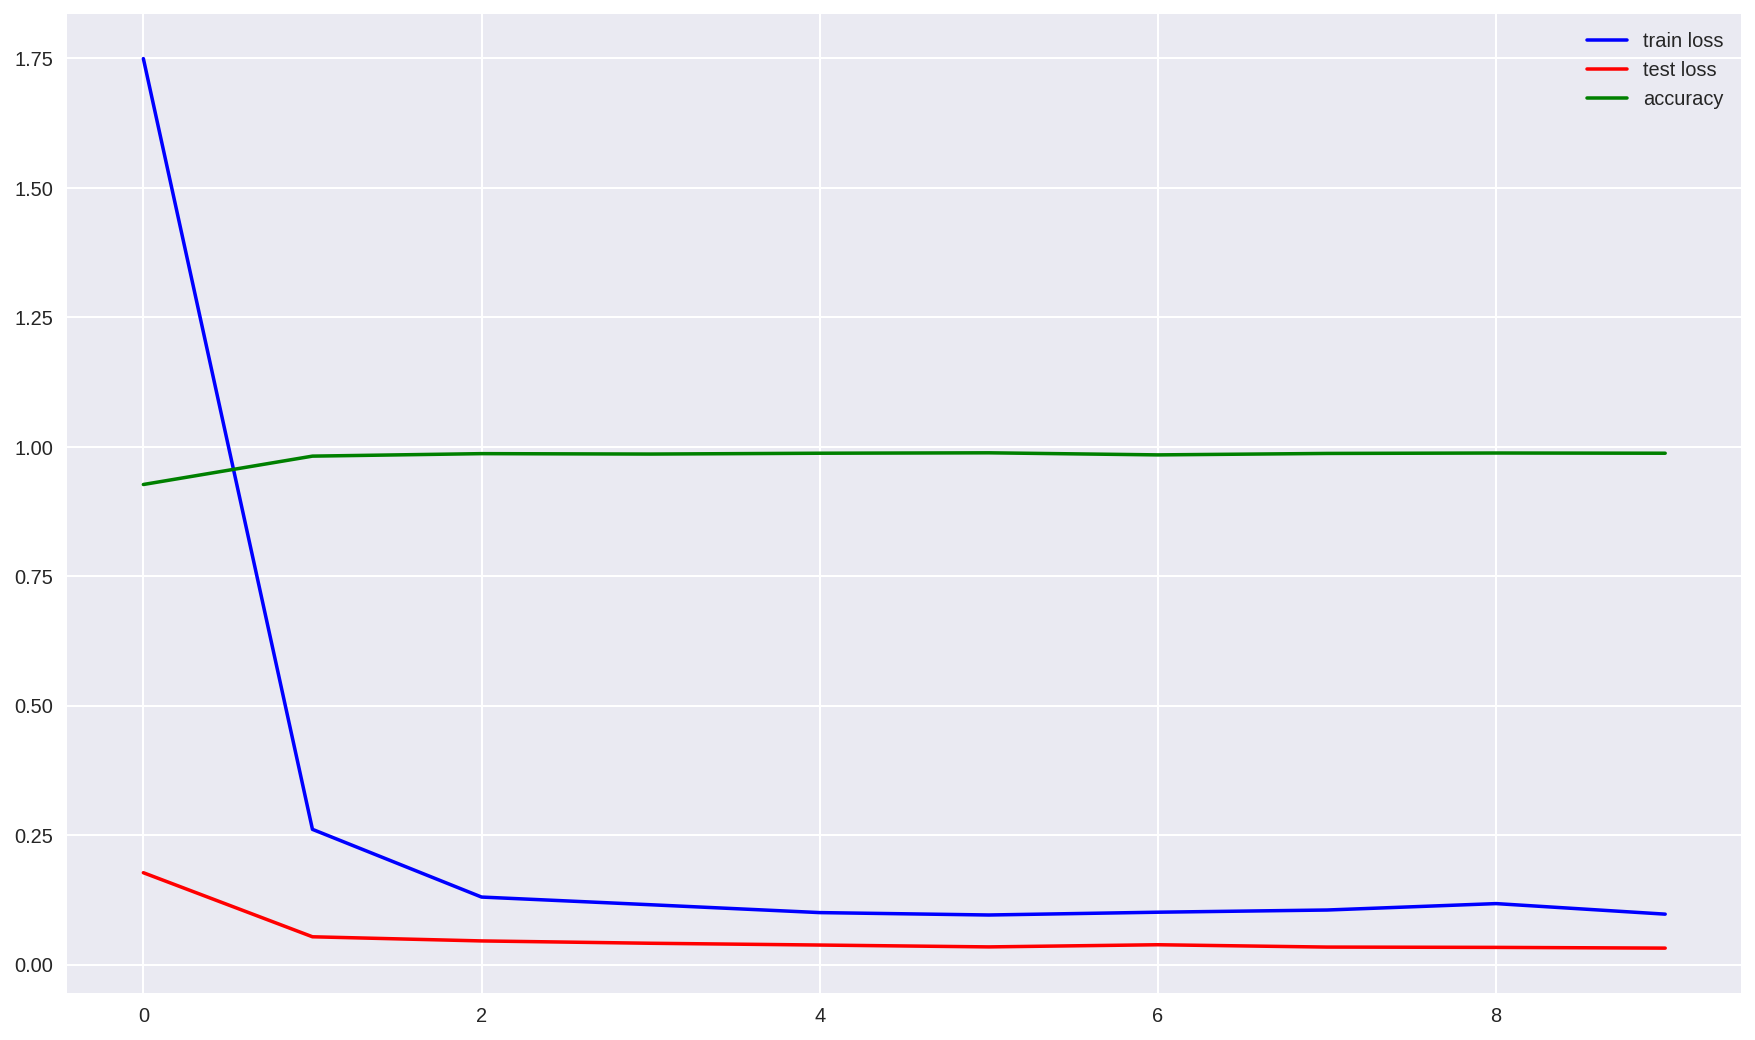

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


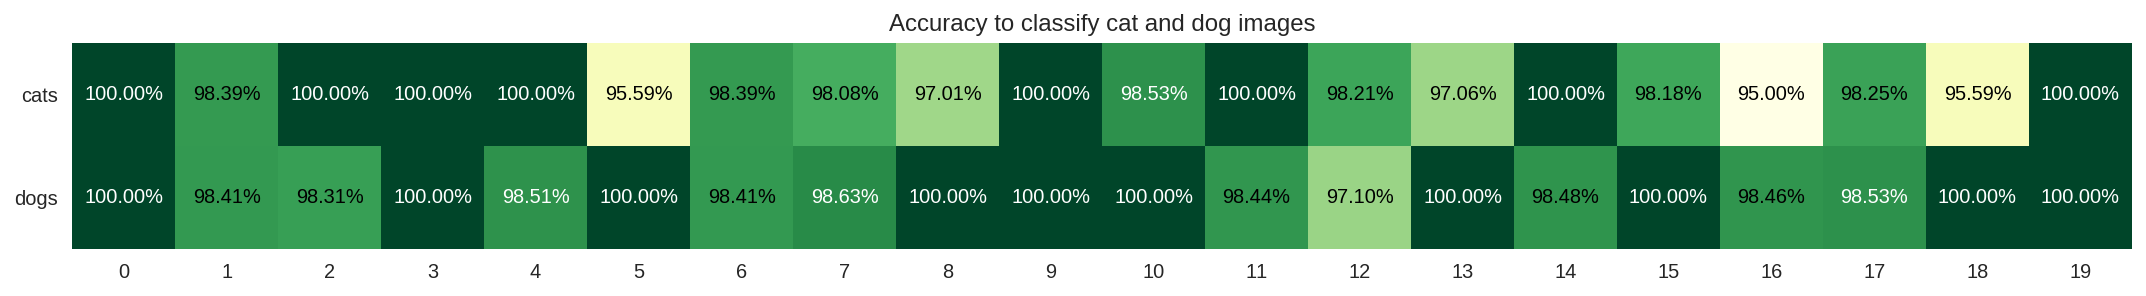

In [13]:
    plt.figure(figsize=(15,9))
    plt.subplot(1,1,1)
    plt.plot(np.array(trace_train_loss), 'b', label='train loss')
    plt.plot(np.array(trace_test_loss), 'r', label='test loss')
    plt.plot(np.array(trace_accuracy), 'g', label='accuracy')
    plt.legend()

    plt.show()

    heatmap(accuracy_graph)